## **Walmart Sales Forecasting**

- Worked on by ***Taufik Budi Wibowo***
- Part of project from Intro to Machine Learning Course
- Dataset from Walmart Recruiting - Store Sales Forecasting - Kaggle Case Study

**Outline**
1. *Business Understanding*
    -  Background of the Project
    - Problem Identification
    - Conceptual Framework
    - Proposed Solutions
2. *Data Understanding*
    - Import Library
    - Data Preparation
    - Exploratory Data Analysis
3. *Feature Engineering*
    - Scalling Data
    - Encode Data
4. *Forecasting Section*

#### **Business understanding**
- ***Background of The Project***

Walmart, a multinational retail corporation, is operating numerous stores across different regions in the United States. In today's data-driven era, companies are increasingly using data to inform their strategic decisions, particularly in the retail industry. Walmart aims to leverage historical sales data from 45 stores with 99 departments each to make informed strategic decisions, improve sales, and optimize their operations.

- ***Problem Identification***

The primary challenge facing Walmart is the need to make effective strategic decisions based on limited historical data. Traditional retail businesses often rely on historical data to plan for seasonal events, but these opportunities come only once a year. In particular, Walmart faces difficulties during key holiday periods, including the Super Bowl, Labor Day, Thanksgiving, and Christmas, where they run promotional markdown events. The challenge is that they lack complete or ideal historical data to model the impact of these markdowns on sales during these holiday weeks. Walmart needs a solution that helps them make data-driven decisions for optimizing sales during these critical holiday periods and throughout the year.

- ***Conceptual Framework***

The conceptual framework for this project involves analyzing historical sales data from 45 stores with 99 departments each, spanning from February 5, 2010, to November 1, 2012. The analysis should focus on understanding sales patterns, especially during significant holiday weeks. These holiday weeks are given five times higher weight in evaluation, indicating their importance in the decision-making process. Walmart aims to identify the impact of promotional markdown events on sales during these holiday weeks and non-holiday weeks.

#### **Data Understanding**

*Import Library*

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import inflection

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

*Data Preparation*

In [26]:
#Read train dataset file
tr_data = pd.read_csv('E:\Bootcamp Technical\Project Intro to ML/train.csv')
tr_data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
#Read test dataset file
ts_data = pd.read_csv('E:\Bootcamp Technical\Project Intro to ML/test.csv')
ts_data.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [28]:
#Read store dataset file
st_data = pd.read_csv('E:\Bootcamp Technical\Project Intro to ML/stores.csv')
st_data.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [29]:
#Read features dataset file
ft_data = pd.read_csv('E:\Bootcamp Technical\Project Intro to ML/features.csv')
ft_data.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [30]:
#Missing Values Analysis

#checking missing values in each dataset
def check_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing>0]
    missing_percentage = (missing/len(df))*100
    missing_val = pd.DataFrame({'NaN_count':missing, 'NaN_percentage':missing_percentage})
    missing_val = missing_val.sort_values(by='NaN_percentage', ascending=False)
    return missing_val

In [31]:
check_missing_values(tr_data)

,NaN_count,NaN_percentage


In [32]:
check_missing_values(ts_data)

,NaN_count,NaN_percentage


In [33]:
check_missing_values(st_data)

,NaN_count,NaN_percentage


In [34]:
check_missing_values(ft_data)

,NaN_count,NaN_percentage
MarkDown2,5269,64.334554
MarkDown4,4726,57.704518
MarkDown3,4577,55.885226
MarkDown1,4158,50.769231
MarkDown5,4140,50.549451
CPI,585,7.142857
Unemployment,585,7.142857


In [35]:
#Fill the missing values
ft_data['CPI'].fillna(ft_data['CPI'].median(), inplace=True)
ft_data['Unemployment'].fillna(ft_data['Unemployment'].median(), inplace=True)

col_fillwna = ['MarkDown2','MarkDown4','MarkDown3','MarkDown1','MarkDown5']
ft_data[col_fillwna] = ft_data[col_fillwna].fillna(0)

In [36]:
check_missing_values(ft_data)

,NaN_count,NaN_percentage


In [37]:
#Merging all data
data = tr_data.merge(ft_data, on=['Store', 'Date', 'IsHoliday'], how='inner')
data = data.merge(st_data, on='Store', how='inner')
data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [38]:
#Unique value from each feature
unique_attribute = []

for col in data.columns:
    unique_attribute.append([col,data[col].unique(),data[col].nunique()])

unique_attribute = pd.DataFrame(data=unique_attribute, columns = ['column','unique_value','total'])
unique_attribute

,column,unique_value,total
0,Store,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",45
1,Dept,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",81
2,Date,"[2010-02-05, 2010-02-12, 2010-02-19, 2010-02-2...",143
3,Weekly_Sales,"[24924.5, 50605.27, 13740.12, 39954.04, 32229....",359464
4,IsHoliday,"[False, True]",2
5,Temperature,"[42.31, 38.51, 39.93, 46.63, 46.5, 57.79, 54.5...",3528
6,Fuel_Price,"[2.572, 2.548, 2.514, 2.561, 2.625, 2.667, 2.7...",892
7,MarkDown1,"[0.0, 10382.9, 6074.12, 410.31, 5629.51, 4640....",2278
8,MarkDown2,"[0.0, 6115.67, 254.39, 98.0, 68.0, 19.0, 67.0,...",1499
9,MarkDown3,"[0.0, 215.07, 51.98, 55805.51, 1398.11, 105.02...",1662


In [39]:
#Convert columns name from camelcase into snakecase 
cols_old_name = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'FuelPrice', 'MarkDown1', 'MarkDown2', 'MarkDown3', 
                 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

snakecase = lambda x: inflection.underscore(x)

cols_newname = list(map(snakecase, cols_old_name))

data.columns = cols_newname

In [40]:
#Re-checking missing values after merging
check_missing_values(data)

,NaN_count,NaN_percentage


In [41]:
#Checking duplicated values
data[data.duplicated(keep=False)].tail(5)

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size


In [42]:
# List of numeric columns to exclude
exclude = ['mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5', 'store', 'dept']

# Filter numeric columns and remove excluded features
num_data = [col for col in data.select_dtypes(include='number').columns if col not in exclude]

*Exploratory Data Analysis (EDA)*

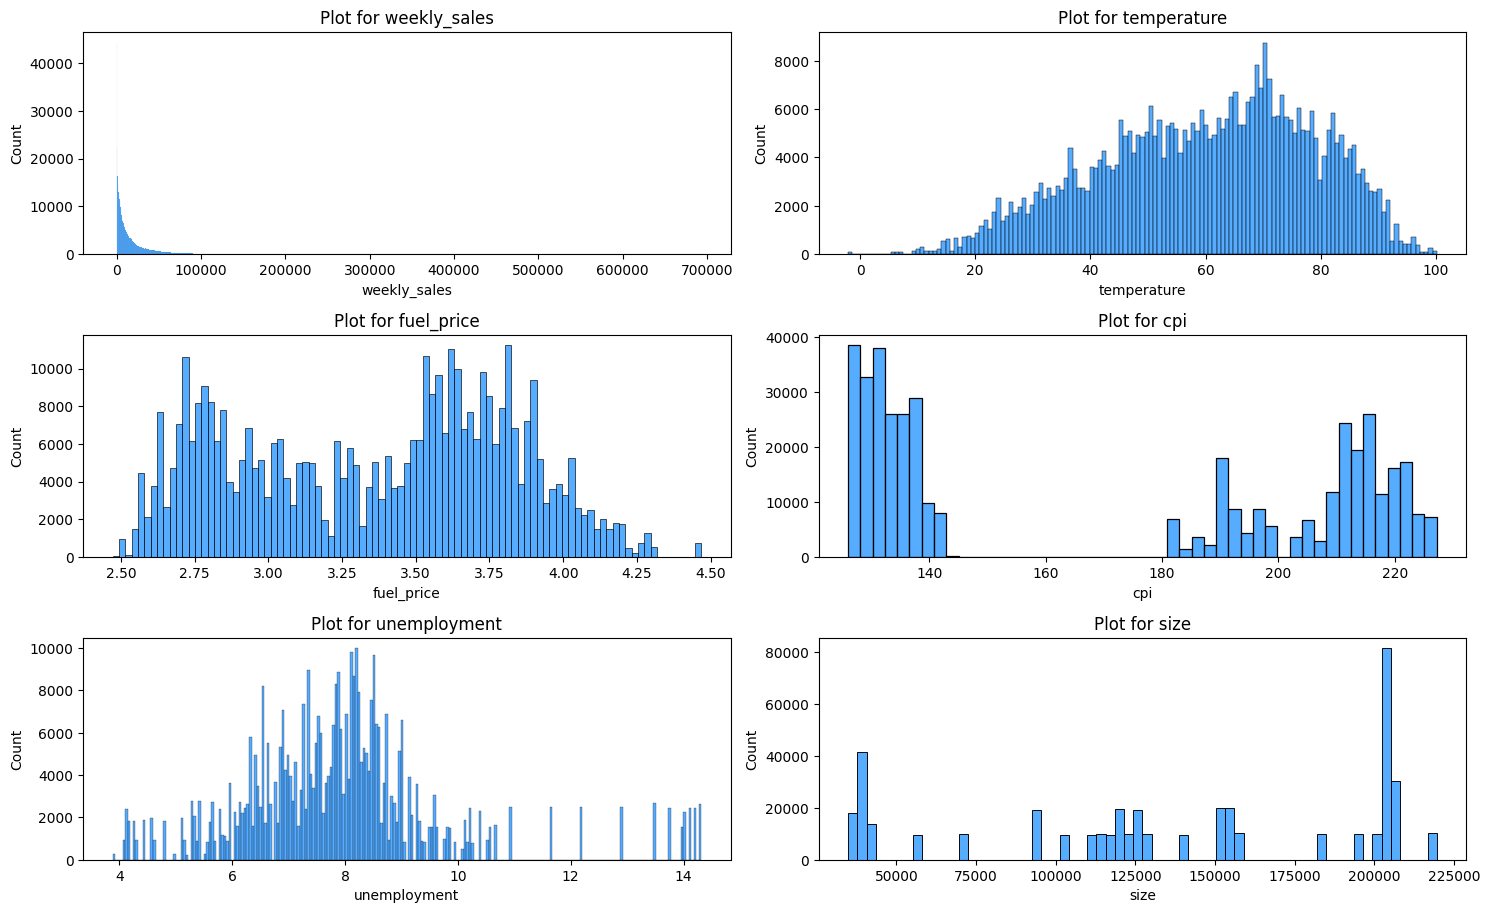

In [43]:
#Visualized the data to know the distribution from numerical features
count = 0 
fig = plt.figure(figsize=(15,30))
for feature in num_data:
    count += 1
    ax = plt.subplot(10,2, count)
    sns.histplot(data=data, x=feature, color='dodgerblue')
    plt.title(f'Plot for {feature}')
    fig.tight_layout()
plt.show()

In [44]:
#Hypothesis testing to make sure the data distribution from numerical features
print('''
H0 : Data Terbukti Terdistribusi Normal
H1 : Data Tidak Terbukti Terdistribusi Normal
apabila p_val >= 0.05 Terima H0, Tolak H1
apabila p_val < 0.05 Tolak H0, Terima H1
''')

for feature in num_data:
    stat, p_val = stats.shapiro(data[feature].dropna())
    if p_val >= 0.05:
        print(f"{feature}\t Terbukti Terdistribusi Normal\n")
    else:
        print(f"{feature}\t Tidak Terbukti Terdistribusi Normal\n")


H0 : Data Terbukti Terdistribusi Normal
H1 : Data Tidak Terbukti Terdistribusi Normal
apabila p_val >= 0.05 Terima H0, Tolak H1
apabila p_val < 0.05 Tolak H0, Terima H1

weekly_sales	 Tidak Terbukti Terdistribusi Normal

temperature	 Tidak Terbukti Terdistribusi Normal

fuel_price	 Tidak Terbukti Terdistribusi Normal

cpi	 Tidak Terbukti Terdistribusi Normal

unemployment	 Tidak Terbukti Terdistribusi Normal

size	 Tidak Terbukti Terdistribusi Normal



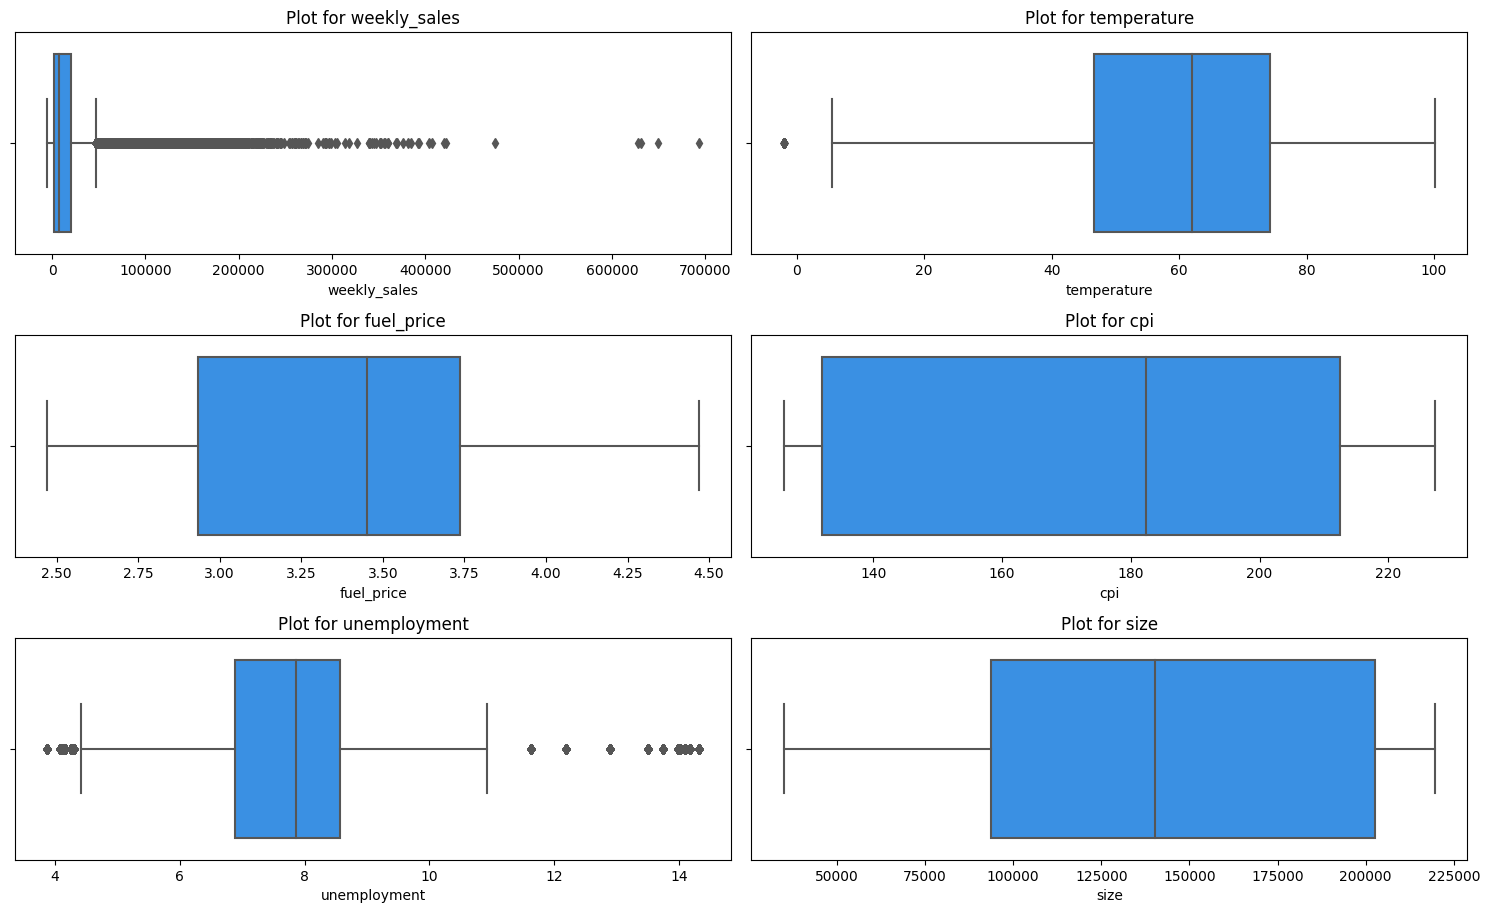

In [45]:
#Checking the outlier
count=0
fig = plt.figure(figsize=(15, 30))
for feature in num_data:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.boxplot(data=data,x=feature, color="dodgerblue")
    plt.title("Plot for {}".format(feature))
    fig.tight_layout()
plt.show()

In [46]:
#Descriptive statistics to get more info about the numerical features
num_feature = data.select_dtypes(include='number')
mean = pd.DataFrame(num_feature.apply(np.mean)).T
median = pd.DataFrame(num_feature.apply(np.median)).T
std = pd.DataFrame(num_feature.apply(np.std)).T
min_value = pd.DataFrame(num_feature.apply(np.min)).T
max_value = pd.DataFrame(num_feature.apply(np.max)).T
range_value = pd.DataFrame(num_feature.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_feature.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_feature.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [47]:
desc_stat

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.000,45.000000,44.000000,22.200546,22.00000,12.785282,0.077763,-1.146503
1,dept,1.000,99.000000,98.000000,44.260317,37.00000,30.492018,0.358223,-1.215571
2,weekly_sales,-4988.940,693099.360000,698088.300000,15981.258123,7612.03000,22711.156583,3.262008,21.491290
3,temperature,-2.060,100.140000,102.200000,60.090059,62.09000,18.447909,-0.321404,-0.635922
4,fuel_price,2.472,4.468000,1.996000,3.361027,3.45200,0.458514,-0.104901,-1.185405
5,mark_down1,0.000,88646.760000,88646.760000,2590.074819,0.00000,6052.378756,4.731304,34.917236
6,mark_down2,-265.760,104519.540000,104785.300000,879.974298,0.00000,5084.532770,10.645956,145.421293
7,mark_down3,-29.100,141630.610000,141659.710000,468.087665,0.00000,5528.866895,14.922341,248.095371
8,mark_down4,0.000,67474.850000,67474.850000,1083.132268,0.00000,3894.525326,8.077666,86.242339
9,mark_down5,0.000,108519.280000,108519.280000,1662.772385,0.00000,4207.624330,9.964519,183.408065


In [48]:
#Drop the negative values from the weekly sales
data = data[data['weekly_sales']>0]

In [49]:
data.head()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [50]:
#Convert a column of data into a pandas datetime data type.
data['date'] = pd.to_datetime(data['date'])

In [51]:
#Separate years, months, and weeks
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week

**Sales vs Time**

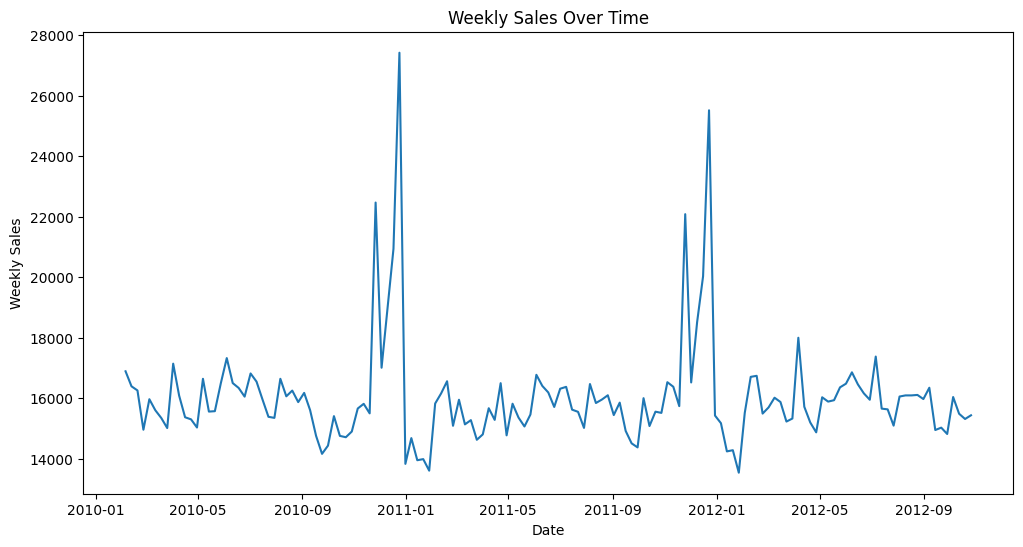

In [52]:
#Weekly sales over time linechart
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='weekly_sales', ci=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.show()

An observable and consistent seasonal pattern emerges, revealing a recurrent surge in weekly sales, year after year, consistently commencing in the month of November and extending through to December. This annual upswing underscores the heightened consumer demand during the holiday season. 

It can give critical insight for inventory management, marketing strategy, and staffing to accommodate the anticipated increase in customer traffic during this period.

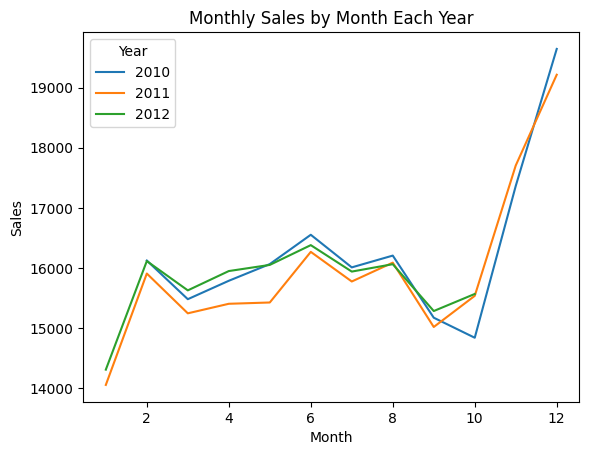

In [53]:
#Monthly weekly sales linechart each year
monthly_sales = pd.pivot_table(data, values='weekly_sales', columns='year', index='month')
monthly_sales.plot(title='Monthly Sales by Month Each Year', ylabel='Sales', xlabel='Month')
plt.legend(title='Year')
plt.show()

- An interesting pattern emerges when observing the graph-2011 shows a marked decline in sales compared to 2010, indicating a general decline in sales during the year. This observation is in line with the analysis of the average sales value, where 2010 has a higher average. 
- A different anomaly appears in the 2012 data; most importantly, **no information is recorded for the favorable months of November and December**, which usually result in higher sales figures. Despite this omission, the 2012 average sales figure remains very close to the 2010 figure, implying that it could potentially claim the top spot if the missing data for November and December 2012 were available and included in the calculations. This underlines the importance of these latter months in driving sales and emphasizes their potential impact on overall performance.

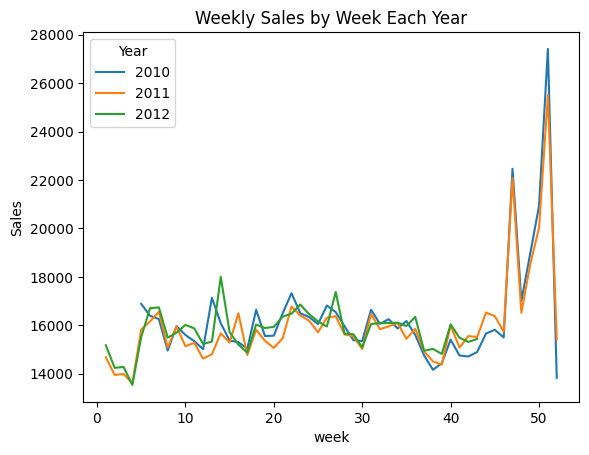

In [54]:
#Weekly sales linechart each year
weekly_sales = pd.pivot_table(data, values='weekly_sales', columns='year', index='week')
weekly_sales.plot(title='Weekly Sales by Week Each Year', ylabel='Sales', xlabel='week')
plt.legend(title='Year')
plt.show()

Looking at the data, we can see two distinct peaks in average sales. First, there is a noticeable spike around week 47, which indicates a substantial increase in sales during this period. This trend most likely reflects the holiday shopping effect, where consumers increase their purchases in preparation for holiday celebrations. In addition, a second peak appears around week 51, which reinforces the presence of the holiday effect. The elevated averages during these particular weeks emphasize the huge impact that holidays have on sales performance, underscoring the importance of adjusting marketing and inventory strategies to capitalize on these peak periods.

**Holiday Effect**

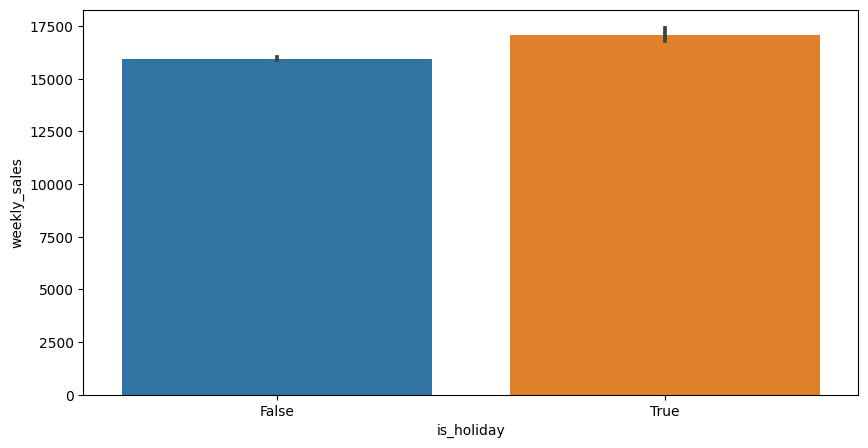

In [55]:
plt.figure(figsize=(10,5))
sns.barplot(x='is_holiday', y='weekly_sales', data=data)
plt.show()

In particular, the data shows that average weekly sales during holidays significantly outperform sales on non-holiday days. This underscores the considerable impact of holidays on sales figures, emphasizing the need for businesses to strategically leverage these peak periods to increase revenue. For more details, I will do a more detailed analysis of the holidays data.

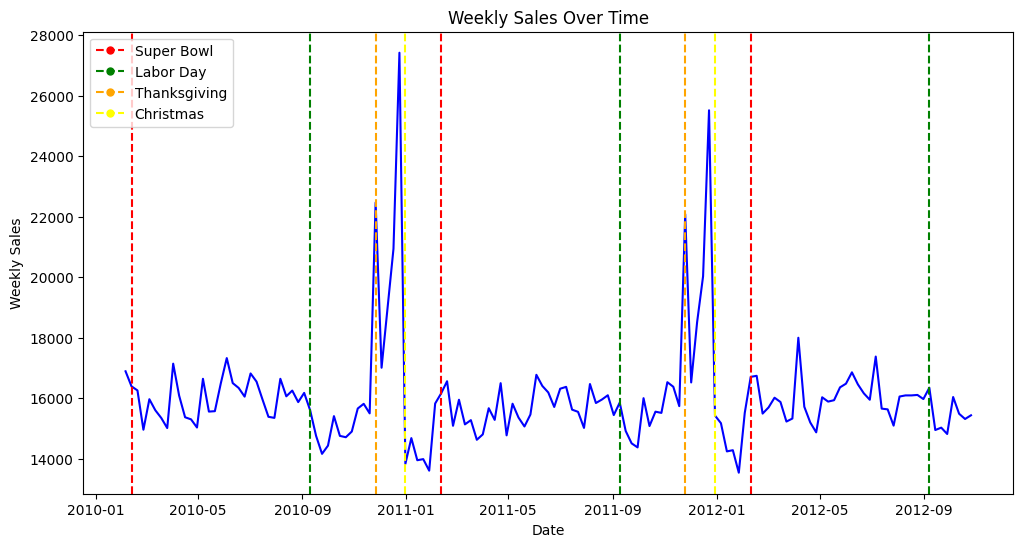

In [56]:
events = {
    'Super Bowl': {
        'dates': ['2010-02-12', '2011-02-11', '2012-02-10'],
        'color': 'red'
    },
    'Labor Day': {
        'dates': ['2010-09-10', '2011-09-09', '2012-09-07'],
        'color': 'green'
    },
    'Thanksgiving': {
        'dates': ['2010-11-26', '2011-11-25'],
        'color': 'orange'
    },
    'Christmas': {
        'dates': ['2010-12-31', '2011-12-30'],
        'color': 'yellow'
    }
}


plt.figure(figsize=(12, 6))

# Plot the line chart for weekly sales
sns.lineplot(data=data, x='date', y='weekly_sales', ci=None, color='b', label='Weekly Sales')

# Highlight event dates with different colors and labels
for event, info in events.items():
    for date in info['dates']:
        date = pd.to_datetime(date)
        plt.axvline(x=date, linestyle='--', color=info['color'])

# Create a simplified legend
legend_labels = [plt.Line2D([0], [0], color=info['color'], linestyle='--', marker='o', markersize=5, label=event) for event, info in events.items()]
plt.legend(handles=legend_labels, loc='upper left')

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.show()

As seen in the line chart above, it is clear that the Thanksgiving period has the highest weekly average sales compared to other holidays. This underscores the noticeable impact Thanksgiving has on sales figures, signaling the need for businesses to strategically utilize this period to increase revenue.

In [57]:
#Super Bowl
data.loc[(data['date']=='2010-02-12')|(data['date']=='2011-02-11')|(data['date']=='2012-02-10'), 'super_bowl'] = True
data.loc[(data['date']!='2010-02-12')&(data['date']!='2011-02-11')&(data['date']!='2012-02-10'), 'super_bowl'] = False

#Labor Day
data.loc[(data['date']=='2010-09-10')|(data['date']=='2011-09-09')|(data['date']=='2012-09-07'), 'labor_day'] = True
data.loc[(data['date']!='2010-09-10')&(data['date']!='2011-09-09')&(data['date']!='2012-09-07'), 'labor_day'] = False

#Thanksgiving
data.loc[(data['date']=='2010-11-26')|(data['date']=='2011-11-25'), 'thanksgiving'] = True
data.loc[(data['date']!='2010-11-26')&(data['date']!='2011-11-25'), 'thanksgiving'] = False

#Christmas
data.loc[(data['date']=='2010-12-31')|(data['date']=='2011-12-30'), 'christmas'] = True
data.loc[(data['date']!='2010-12-31')&(data['date']!='2011-12-30'), 'christmas'] = False

In [58]:
#Each holiday barplot
def holiday_barplot(data, holidays):
    # Create subplots for each holiday
    fig, axes = plt.subplots(1, len(holidays), figsize=(15, 5))
    
    # Loop through each holiday and create a bar plot
    for i, holiday_name in enumerate(holidays):
        sns.barplot(x=holiday_name, y='weekly_sales', data=data, ax=axes[i])
        axes[i].set_title(holiday_name)
    
    plt.tight_layout()
    plt.show()

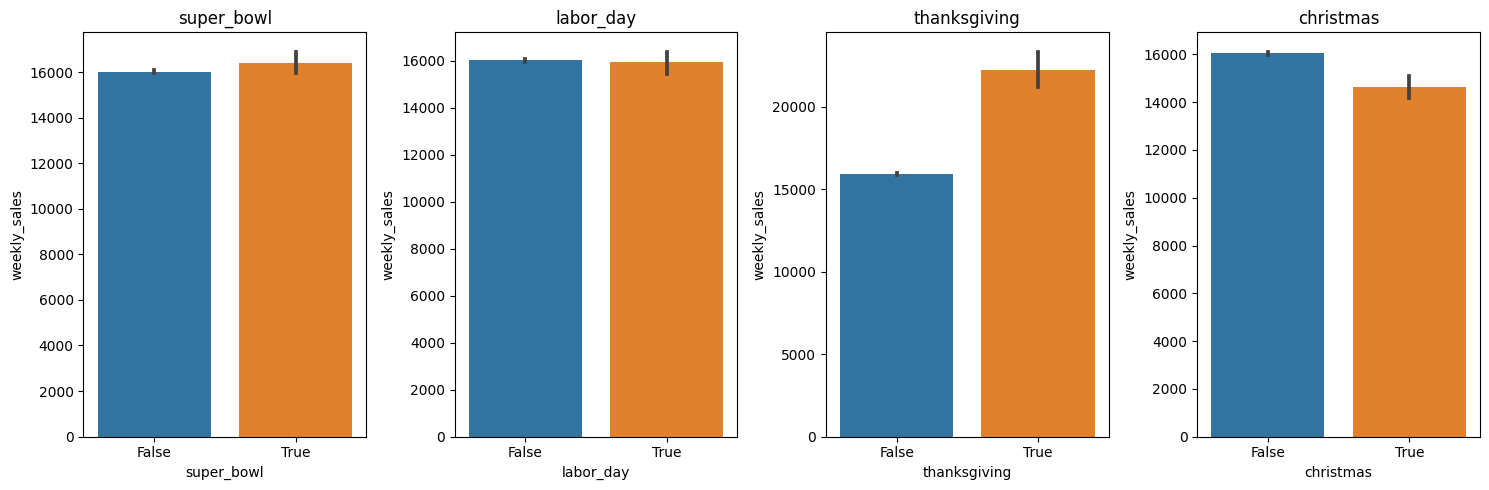

In [59]:
holidays = ['super_bowl', 'labor_day', 'thanksgiving', 'christmas']
holiday_barplot(data, holidays)

Notably, the Thanksgiving period saw the highest weekly average sales when compared to other holidays, as evidenced by the sizable gap between the average weekly sales on Thanksgiving and holidays other than Thanksgiving. The average weekly sales on Thanksgiving specifically exceeded $20,000, underscoring the outstanding sales performance during this holiday period. This underscores the compelling impact of Thanksgiving as a key driver of sales, which emphasizes the importance of strategic planning to maximize revenue during this season.

**Store Type Analysis**

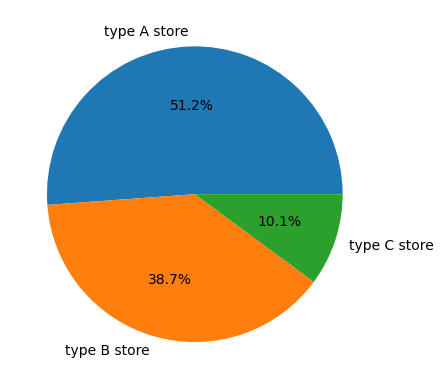

In [60]:
#Percentage each type store from all store
storetype_count = data['type'].value_counts()
store_index = storetype_count.index.tolist()
labels_name = {'A':'type A store', 'B':'type B store', 'C':'type C store'}
labels = [labels_name.get(x, '') for x in store_index]
plt.pie(storetype_count, labels=labels, autopct='%1.1f%%')
plt.show()

From the above pie chart, it can be seen that store type A represents the largest store composition, accounting for 51.2% of the total stores. It is followed by store type B, which represents 38.7%, and store type C, which comprises 10.1% of the distribution. This breakdown highlights the distribution of store types in the dataset and allows a clear understanding of the relative proportion of each type.

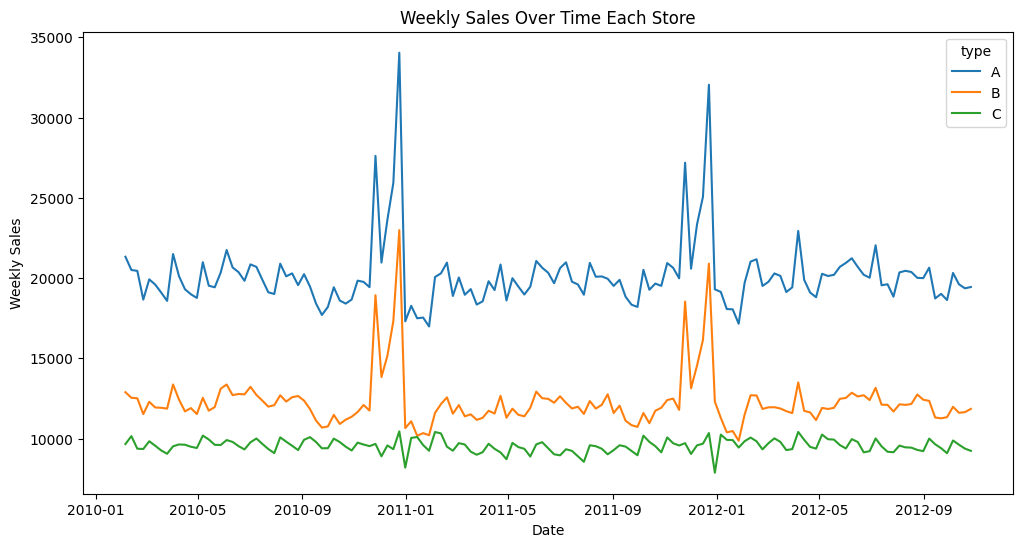

In [61]:
#Weekly sales over time each store type
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='weekly_sales', hue='type', ci=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time Each Store')
plt.show()

The clustering of store categories is further supported by a line chart depicting the trend of weekly sales over time for each store type. The data in this chart very clearly shows that store type A has consistently maintained much higher weekly sales over time when compared to other store types. This dual insight underscores that store type A's dominance in sales is not only a consistent trend, but also contributes significantly to overall sales performance.

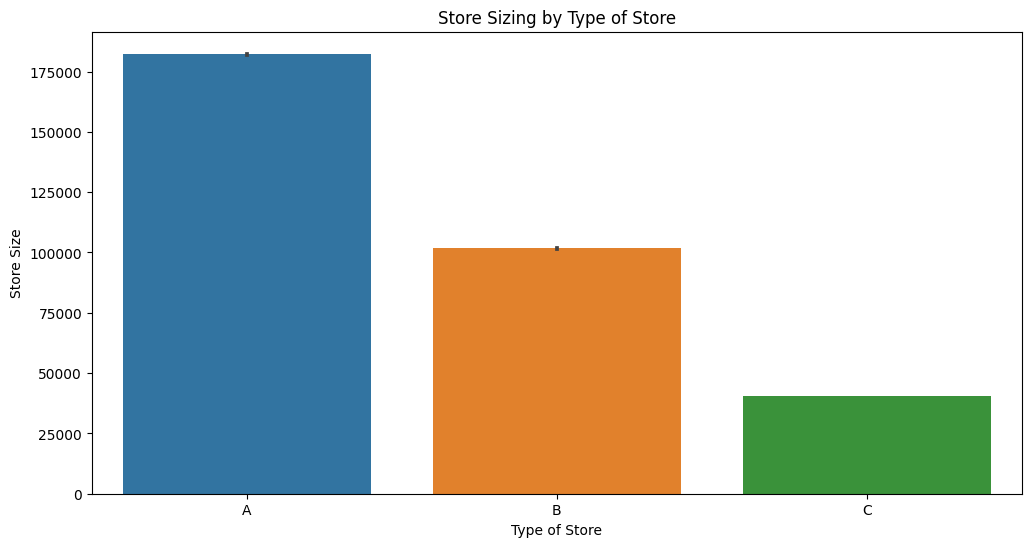

In [62]:
#Type of store vs store sizing
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='type', y='size')
plt.xlabel('Type of Store')
plt.ylabel('Store Size')
plt.title('Store Sizing by Type of Store')
plt.show()

The findings from the pie chart depicting store type are further reinforced by the store size data. In particular, there is a linear relationship between store type and store size. This is clearly demonstrated by the fact that store type A, which represents the largest store composition, has the largest store size value among all store types. This correspondence underscores the direct correlation between store type and store size, with store type A having the largest size, which further strengthens the understanding of store type distribution.

**Markdown analysis**

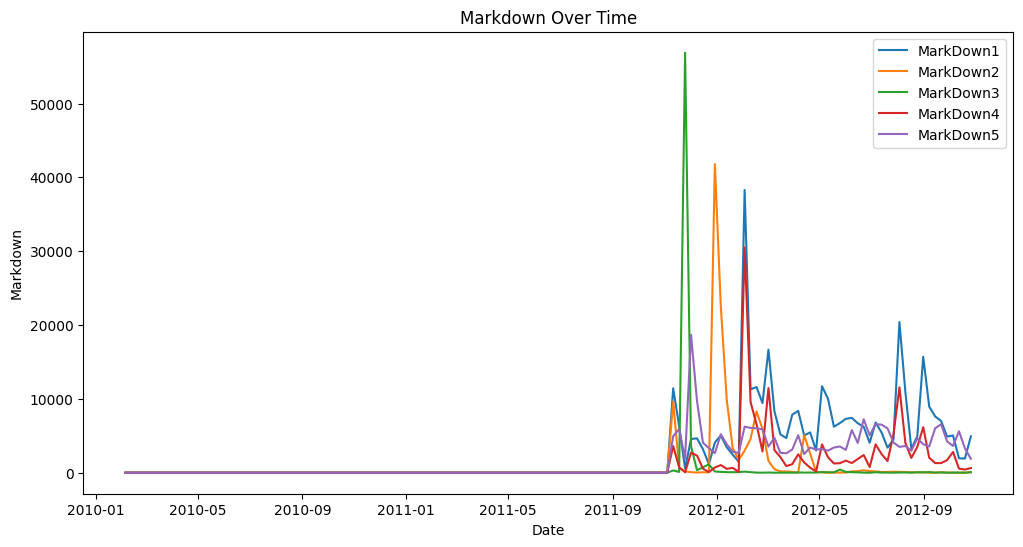

In [63]:
#Markdown Over Time

plt.figure(figsize=(12, 6))

# Plot MarkDown1
sns.lineplot(data=data, x='date', y='mark_down1', ci=None, label='MarkDown1')

# Plot MarkDown2
sns.lineplot(data=data, x='date', y='mark_down2', ci=None, label='MarkDown2')

# Plot MarkDown3
sns.lineplot(data=data, x='date', y='mark_down3', ci=None, label='MarkDown3')

# Plot MarkDown4
sns.lineplot(data=data, x='date', y='mark_down4', ci=None, label='MarkDown4')

# Plot MarkDown5
sns.lineplot(data=data, x='date', y='mark_down5', ci=None, label='MarkDown5')

plt.xlabel('Date')
plt.ylabel('Markdown')
plt.title('Markdown Over Time')
plt.legend()
plt.show()

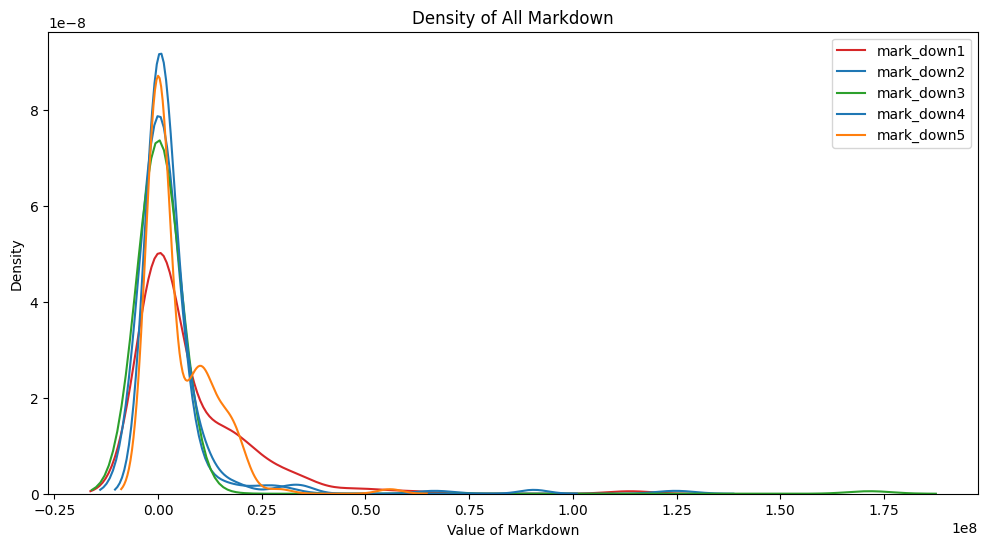

In [64]:
#Markdown Value Density

plt.figure(figsize=(12, 6))

# Plot the kernel density estimate for MarkDown1
sns.kdeplot(data.groupby(['date'])['mark_down1'].sum(), label='mark_down1', color="tab:red")

# Plot the kernel density estimate for MarkDown2
sns.kdeplot(data.groupby(['date'])['mark_down2'].sum(), label='mark_down2', color="tab:blue")

# Plot the kernel density estimate for MarkDown3
sns.kdeplot(data.groupby(['date'])['mark_down3'].sum(), label='mark_down3', color="tab:green")

# Plot the kernel density estimate for MarkDown4
sns.kdeplot(data.groupby(['date'])['mark_down4'].sum(), label='mark_down4')

# Plot the kernel density estimate for MarkDown5
sns.kdeplot(data.groupby(['date'])['mark_down5'].sum(), label='mark_down5')

plt.title('Density of All Markdown')
plt.xlabel('Value of Markdown')
plt.ylabel('Density')
plt.legend()
plt.show()


- It is evident that until early December 2011, no price drops were available in the dataset.

- All markdown values show a spike that started in late December 2011. During this period, markdown 3 has the highest spike, but after entering the early months of 2012, markdown 2 surpasses all others in the dataset, followed by markdown 1 as it approaches February and beyond.

- Markdown 1 shows a higher density value compared to the other markdowns, indicating that it is used more frequently than the other markdowns. This suggests that markdown 1 is the most frequently used among the markdown strategies.

**Weekly Sales by Department and Store**

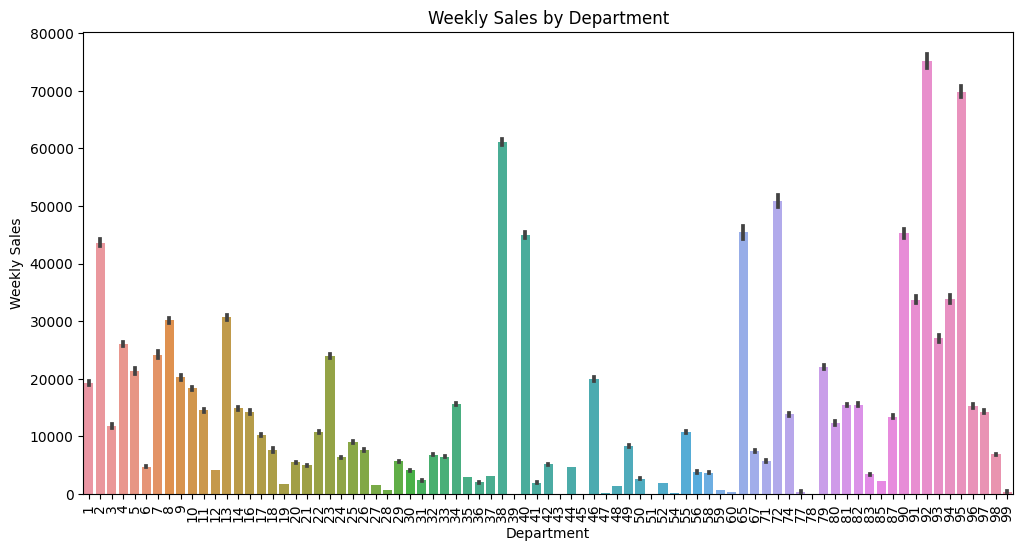

In [65]:
#Weekly sales vs department

#Sort the data by weekly sales
data_sorted = data.sort_values(by='weekly_sales')

plt.figure(figsize=(12, 6))
sns.barplot(data=data_sorted, x='dept', y='weekly_sales')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.title('Weekly Sales by Department')
plt.show()

In the bar chart depicting weekly sales by department, it is clear that Department 92 consistently generates the highest weekly sales when compared to other departments. The correlation analysis shows a positive relationship between Department 92 and weekly sales, indicating that this department significantly affects overall sales performance.

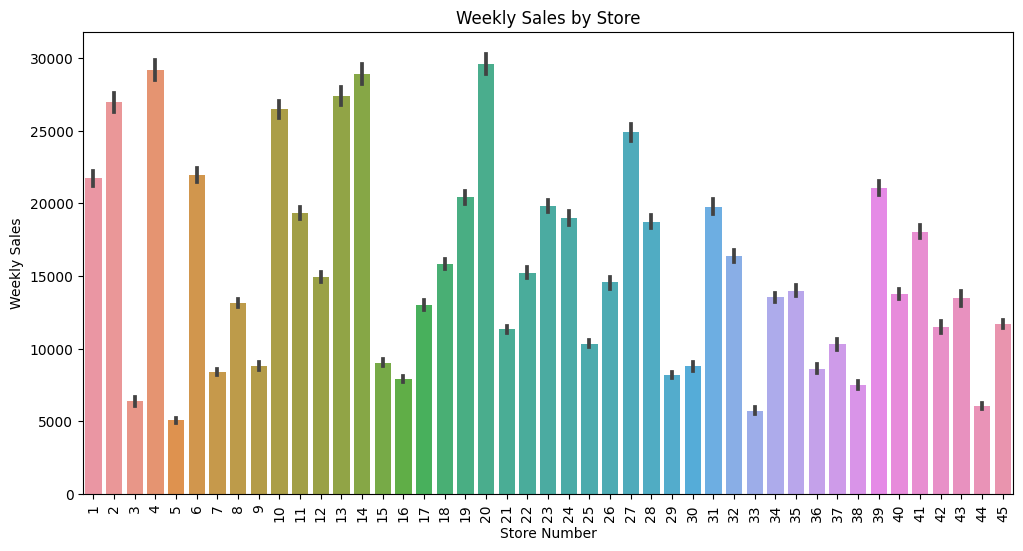

In [66]:
#Weekly sales vs store

#Sort the data by weekly sales
data_sorted = data.sort_values(by='weekly_sales')

plt.figure(figsize=(12, 6))
sns.barplot(data=data_sorted, x='store', y='weekly_sales')
plt.xlabel('Store Number')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.title('Weekly Sales by Store')
plt.show()

The bar chart for weekly sales per store underlines that Store 20 consistently achieved the highest weekly sales among all stores. Correlation analysis shows a strong positive correlation between Store 20 and weekly sales, which highlights the important role this store plays in driving sales.

**Fuel Price, Temperature, CPI, and Unemployment vs Over Time**

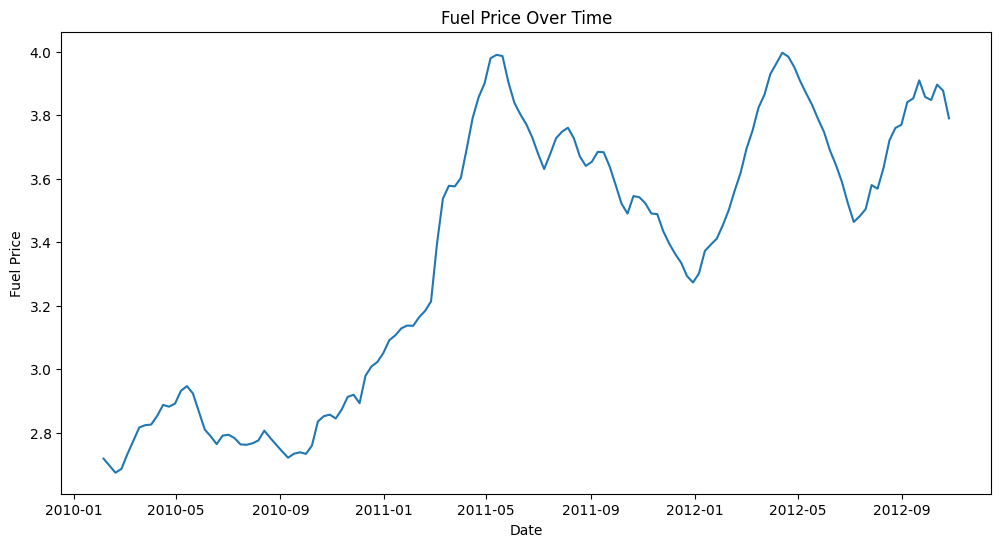

In [67]:
#Fuel price over time
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='fuel_price', ci=None)
plt.xlabel('Date')
plt.ylabel('Fuel Price')
plt.title('Fuel Price Over Time')
plt.show()

date        
2010  315033   2010-07-16
2011  317680   2011-08-26
2012  319989   2012-08-10
Name: date, dtype: datetime64[ns]


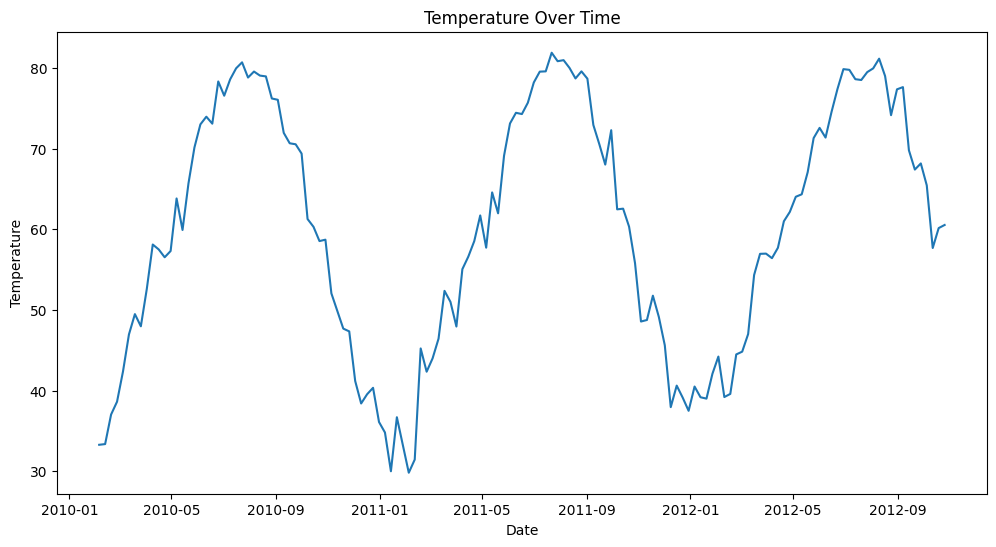

In [68]:
#Temperature over time

#Sort the data by temperature and print the top of temperature value from each year
data = data.sort_values(by='temperature', ascending=False)
top_temps = data.groupby(data['date'].dt.year).apply(lambda x: x.nlargest(1, ['temperature']))
print(top_temps['date'])

plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='temperature', ci=None)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.show()

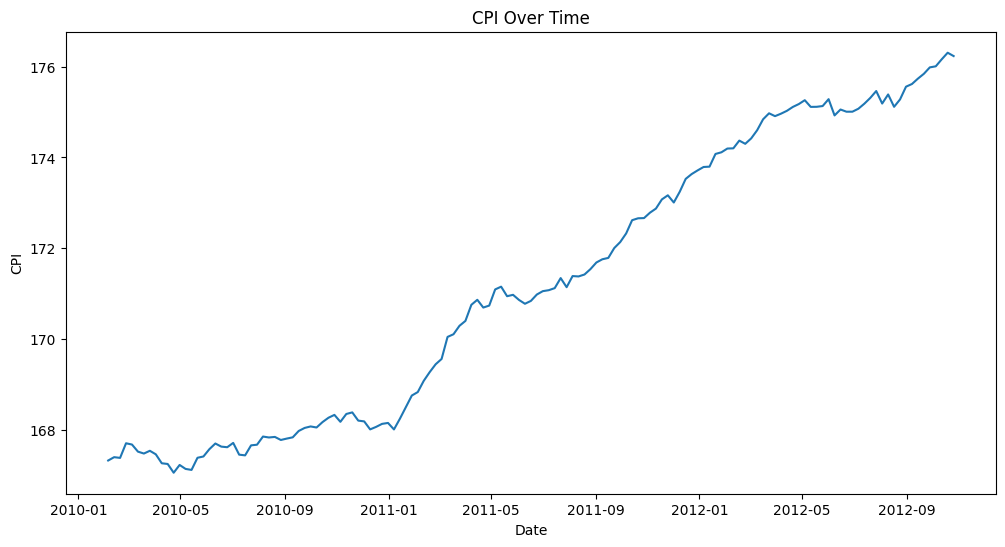

In [69]:
#CPI over time
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='cpi', ci=None)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Over Time')
plt.show()

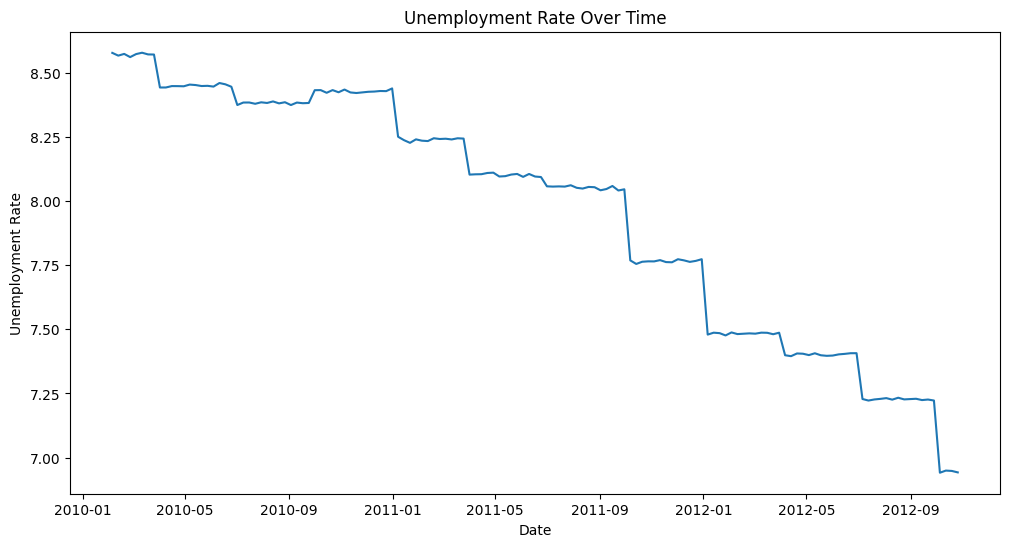

In [70]:
#Unemployment over time
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='date', y='unemployment', ci=None)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.show()

- After taking a closer look at the line graphs for Fuel Price over time and CPI over time, it is clear that both show similar patterns in terms of increasing values over time, although not consistently. However, when a correlation analysis with weekly sales was conducted, the results showed no significant correlation between Fuel Price, CPI, and weekly sales, indicating that changes in these two variables may not have a significant effect on sales trends.

- In the case of the line graph depicting temperature over time, notable peaks were seen on 2010-07-16, 2011-08-26, and 2012-08-10. However, when a correlation analysis with weekly sales is conducted, the findings do not show a significant correlation between the temperature peaks and sales, implying that these particular temperature conditions may not have a great impact on sales.

- Lastly, the line graph tracking unemployment over time depicts a gradual decline over the observation period. However, when examined through correlation analysis with weekly sales, the results show no significant correlation between unemployment and sales. This suggests that the unemployment rate may not be an important factor affecting sales trends.

**Correlation Heatmap**

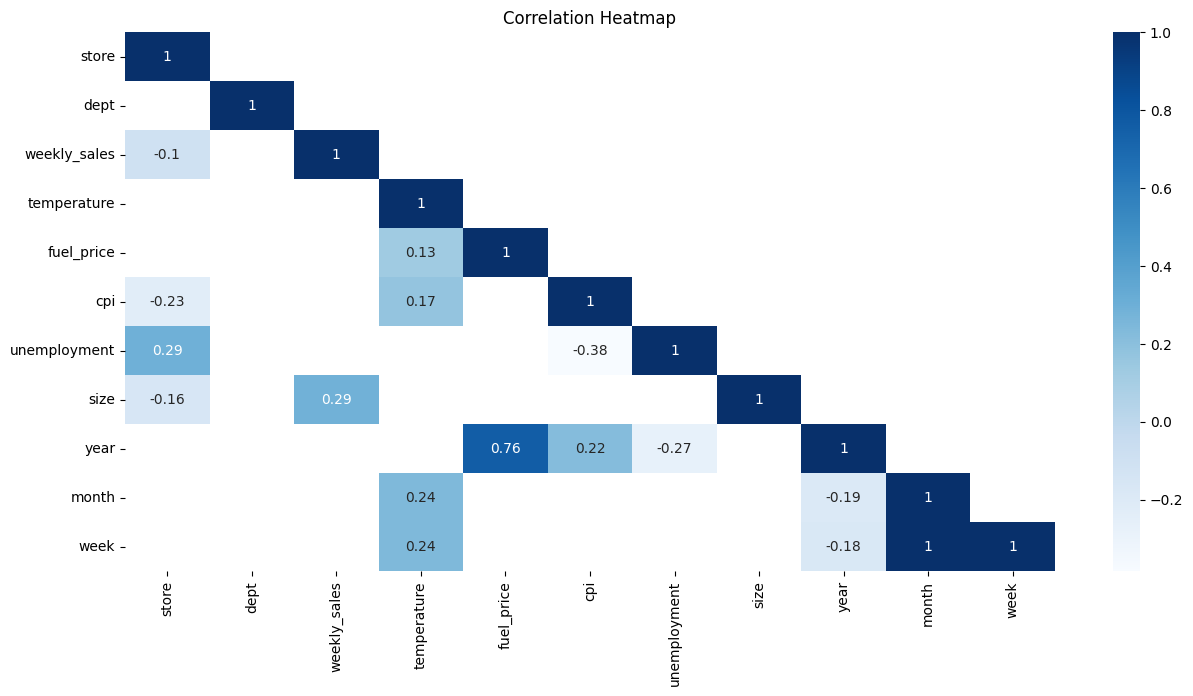

In [71]:
#Correlation Heatmap
exclude_columns = ['mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5']
numerical_columns = [col for col in data.select_dtypes(include=['number']).columns if col not in exclude_columns]
data_corr = data[numerical_columns].corr(method="spearman")

plt.figure(figsize=(15, 7))
trimask = np.triu(np.ones_like(data_corr), k=1)  # Use k=1 to exclude the diagonal
sns.heatmap(data=data_corr, annot=True, cmap="Blues", mask=trimask | (np.abs(data_corr) <= 0.1))
plt.title("Correlation Heatmap")
plt.show()

From the correlation heatmap we get a linear correlation value between features but this does not give us any significant and useful insight.

**Conclusions from EDA**

1. **Holiday Season Sales Impact**: The data underscores the substantial impact of the holiday season, which consistently drives increased weekly sales from November to December, especially when Thanksgiving holiday. This seasonal trend highlights the importance of meticulous inventory management, tailored marketing strategies, and appropriate staffing to accommodate the surge in customer demand during this critical period.

2. **Store Type Significance**: Store type A consistently outperforms other store types in terms of weekly sales, maintaining a dominant position throughout the dataset. This finding emphasizes the need for businesses to focus on optimizing strategies for store type A to maximize overall sales performance.

3. **Markdown Strategies**: The analysis of markdowns reveals that markdown 1 is the most frequently used strategy, while markdowns 2 and 3 show spikes during specific periods. This highlights the importance of carefully considering the impact of markdowns on sales and making strategic adjustments as needed.

4. **Department Performance**: Department 92 consistently generates the highest weekly sales, indicating its significant influence on overall sales performance. Retailers should prioritize this department when planning inventory and marketing strategies.

5. **Limited Impact of External Factors**: Correlation analysis suggests that external factors such as Fuel Price, CPI, temperature, and unemployment do not have a significant impact on weekly sales trends. The primary drivers of sales performance appear to be internal factors, such as store type, department, and seasonal patterns. Therefore, businesses should focus on optimizing these internal elements to enhance sales outcomes.

#### **Feature Engineering**

*Scaling Data*

In [72]:
minmaxscalar = MinMaxScaler(feature_range=(0,1))
def normalization(data,col):
    for i in col:
        feature = data[i]
        feature = np.array(feature)
        data[i] = minmaxscalar.fit_transform(feature.reshape(len(feature),1))
    return data

*Encode Data*

In [73]:
encode_cat_col = data.select_dtypes(exclude='number')

for col in encode_cat_col:
   data[col] = LabelEncoder().fit_transform(data[col])

In [74]:
data.head()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,...,unemployment,type,size,year,month,week,super_bowl,labor_day,thanksgiving,christmas
315033,33,46,23,1855.12,0,100.14,2.971,0.0,0.0,0.0,...,9.495,0,39690,2010,7,28,0,0,0,0
315042,33,82,23,2504.58,0,100.14,2.971,0.0,0.0,0.0,...,9.495,0,39690,2010,7,28,0,0,0,0
315034,33,52,23,5.68,0,100.14,2.971,0.0,0.0,0.0,...,9.495,0,39690,2010,7,28,0,0,0,0
315035,33,55,23,9.00,0,100.14,2.971,0.0,0.0,0.0,...,9.495,0,39690,2010,7,28,0,0,0,0
315036,33,60,23,79.20,0,100.14,2.971,0.0,0.0,0.0,...,9.495,0,39690,2010,7,28,0,0,0,0


#### **Forecasting Section**

*Train-Test Split*

In [75]:
Y_train = data['weekly_sales']
X_train = data.drop(columns=['weekly_sales'])
X_test = data.drop(columns=['weekly_sales'])

In [76]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X_train,Y_train, test_size=0.2)

In the evaluation of five distinct models on the training data, which included the **baseline model (mean)**, **linear regression**, **random forest**, **xgboost**, and **lightgbm**, the central objective was to identify the model that demonstrated the most favorable performance characteristics for the given task. The primary focus during the selection process was placed on the Weighted Mean Absolute Error (WMAE) – a crucial indicator of a model's predictive accuracy. This metric is particularly significant in tasks where the consequences of underestimating or overestimating outcomes are uneven, as it helps assess how well a model minimizes these errors.

*Build Helper Function*

In [77]:
def WMAE(dataset, real, predicted):
    weights = dataset.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real - predicted))/(np.sum(weights)), 2)

In [78]:
def rmse(a,b):
    return mean_squared_error(a,b, squared=False)

**Baseline Model (Mean)**

In [79]:
mean = np.mean(Y_train)
predict_val = np.full(data.shape[0], mean)
WMAE(data, Y_train, predict_val)

15350.22

**Linear Regression Section**

In [80]:
linear_regression_model = SGDRegressor()
linear_regression_model.fit(train_inputs, train_targets)
linear_regression_predictions = linear_regression_model.predict(val_inputs)
linear_regression_score = WMAE(val_inputs, val_targets, linear_regression_predictions)
print("Linear Regression WMAE:", linear_regression_score)

Linear Regression WMAE: 2.1581188985427037e+17


In [81]:
train_predictions = linear_regression_model.predict(train_inputs)
train_mae = mean_absolute_error(train_targets, train_predictions)
val_mae = mean_absolute_error(val_targets, linear_regression_predictions)

print("Train MAE:", train_mae)
print("Validation MAE:", val_mae)

Train MAE: 2.0769680735427578e+17
Validation MAE: 2.0846371861957187e+17


**Random Forest Section**

In [82]:
RandomForest_model = RandomForestRegressor()
RandomForest_model.fit(train_inputs, train_targets)
RandomForest_predictions = RandomForest_model.predict(val_inputs)
RandomForest_score = WMAE(val_inputs, val_targets, RandomForest_predictions)
print("Random Forest WMAE:", RandomForest_score)

Random Forest WMAE: 1593.3


In [83]:
train_predictions = RandomForest_model.predict(train_inputs)
train_mae = mean_absolute_error(train_targets, train_predictions)
val_mae = mean_absolute_error(val_targets, RandomForest_predictions)

print("Train MAE:", train_mae)
print("Validation MAE:", val_mae)

Train MAE: 525.5863696991693
Validation MAE: 1431.5665940066392


**XGBoost Section**

In [84]:
XGBoost_model = xgb.XGBRegressor()
XGBoost_model.fit(train_inputs, train_targets)
XGBoost_predictions = XGBoost_model.predict(val_inputs)
XGBoost_score = WMAE(val_inputs, val_targets, XGBoost_predictions)
print("XGBoost WMAE:", XGBoost_score)

XGBoost WMAE: 3132.0


In [85]:
train_predictions = XGBoost_model.predict(train_inputs)
train_mae = mean_absolute_error(train_targets, train_predictions)
val_mae = mean_absolute_error(val_targets, XGBoost_predictions)

print("Train MAE:", train_mae)
print("Validation MAE:", val_mae)

Train MAE: 2954.8386180196035
Validation MAE: 3034.8614115780365


**LightGBM Section**

In [86]:
LightGBM_model = LGBMRegressor(verbosity=-1)
LightGBM_model.fit(train_inputs, train_targets)
LightGBM_predictions = LightGBM_model.predict(val_inputs)
LightGBM_score = WMAE(val_inputs, val_targets, LightGBM_predictions)
print("LightGBM WMAE:", LightGBM_score)

LightGBM WMAE: 4288.22


In [87]:
train_predictions = LightGBM_model.predict(train_inputs)
train_mae = mean_absolute_error(train_targets, train_predictions)
val_mae = mean_absolute_error(val_targets, LightGBM_predictions)

# Mencetak hasil
print("Train MAE:", train_mae)
print("Validation MAE:", val_mae)

Train MAE: 4091.4772278526307
Validation MAE: 4147.622329198225


**Hyperparameter Tuning on Selected Model (RandomForest)**

Among the models under consideration, the random forest model emerged as the most promising choice, primarily due to its achievement of the **lowest WMAE value** among the competing models, a remarkable 1601.57. This figure emphasizes the random forest model's proficiency in providing highly precise and accurate predictions, a vital requirement in many practical applications. 

Moreover, the model's performance is supported by the values of the Mean Absolute Error (MAE) on both the training and validation datasets. With a training MAE of 529.86, the model demonstrates its ability to minimize absolute prediction errors when trained on the data. The validation MAE, which is crucial for assessing a model's generalization capability, also aligns favorably at 1423.53, affirming the model's consistency and robust performance in making accurate predictions on new, unseen data. 

In essence, the random forest model's selection is substantiated by the compelling combination of minimized WMAE, low training MAE, and well-matched validation MAE, collectively highlighting its proficiency as the optimal choice among the models considered for the task.

Aiming to further optimize the Random Forest model's performance, the next step involves conducting hyperparameter tuning.

In [89]:
# # Define the hyperparameters to tune
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [10, 20, 30]
# }

# # Create a Random Forest Regressor object
# RandomForestModel = RandomForestRegressor()

# # Create a GridSearchCV object with 5-fold cross-validation
# grid_search = GridSearchCV(RandomForestModel, param_grid, cv=5)

# # Fit the GridSearchCV object to the training data
# grid_search.fit(train_inputs, train_targets)

# # Print the best hyperparameters and the corresponding WMAE
# print(f'Best hyperparameters: {grid_search.best_params_}')
# print(f'WMAE for RandomForest: {WMAE(val_inputs, val_targets, grid_search.predict(val_inputs))}')

In [90]:
n_estimators = [100,150,200]
max_depth = [10,20,30]

for i in n_estimators:
    for x in max_depth:
        RandomForestModel = RandomForestRegressor(n_estimators=i, max_depth=x)
        RandomForestModel.fit(train_inputs, train_targets)
        y_pred = RandomForestModel.predict(val_inputs)
        print(f'WMAE for RandomForest:{WMAE(val_inputs,val_targets,y_pred)}, n_estimators: {i}, max_depth: {x}')
        print()

WMAE for RandomForest:4340.95, n_estimators: 100, max_depth: 10

WMAE for RandomForest:1654.71, n_estimators: 100, max_depth: 20

WMAE for RandomForest:1600.0, n_estimators: 100, max_depth: 30

WMAE for RandomForest:4330.0, n_estimators: 150, max_depth: 10

WMAE for RandomForest:1644.16, n_estimators: 150, max_depth: 20

WMAE for RandomForest:1598.64, n_estimators: 150, max_depth: 30

WMAE for RandomForest:4328.76, n_estimators: 200, max_depth: 10

WMAE for RandomForest:1644.01, n_estimators: 200, max_depth: 20

WMAE for RandomForest:1592.43, n_estimators: 200, max_depth: 30



**Evaluate Selected Model**

In [91]:
RandomForest_fixmodel = RandomForestRegressor(n_estimators=200, max_depth=30)
RandomForest_fixmodel.fit(train_inputs, train_targets)

print(f'RandomForest Score from Train Fix Model: {RandomForest_fixmodel.score(train_inputs, train_targets)}')
print(f'RandomForest Score from Test Fix Model: {RandomForest_fixmodel.score(val_inputs,val_targets)}')

traindata_pred = RandomForest_fixmodel.predict(train_inputs)
print(f'RMSE score for RandomForest Fix Model: {rmse(traindata_pred, train_targets)}')

RandomForest Score from Train Fix Model: 0.9967014447812541
RandomForest Score from Test Fix Model: 0.9726284159110079
RMSE score for RandomForest Fix Model: 1304.6505652313697


In [93]:
importance_features = pd.DataFrame({
    'feature': X_test.columns,
    'values of importance': RandomForest_fixmodel.feature_importances_
}).sort_values('values of importance', ascending=False)

importance_features.head(5)

,feature,values of importance
1,dept,0.629612
14,size,0.191658
0,store,0.054252
17,week,0.026457
11,cpi,0.023234


**Apply in Other Dataset**

In [110]:
testdata_pred = RandomForest_fixmodel.predict(X_test)
# create a pandas Series from the testdata_pred array
sales_series = pd.Series(testdata_pred)

# assign the values to the weekly_sales column using the Series
ts_data['weekly_sales'] = sales_series

In [113]:
ts_data.head()

,store,dept,date,weekly_sales
0,1,1,2012-11-02,1860.012950
1,1,2,2012-11-02,2499.949800
2,1,3,2012-11-02,8.071308
3,1,4,2012-11-02,16.203400
4,1,5,2012-11-02,85.456019


In [115]:
#Convert a column of data into a pandas datetime data type.
ts_data['date'] = pd.to_datetime(ts_data['date'])

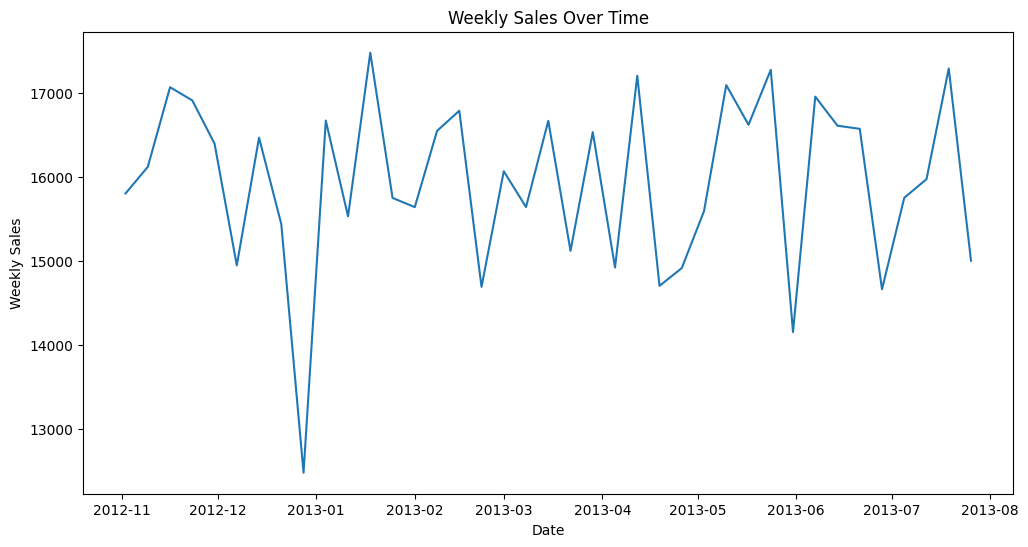

In [116]:
#Weekly sales over time linechart
plt.figure(figsize=(12,6))
sns.lineplot(data=ts_data, x='date', y='weekly_sales', ci=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.show()